In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ssl
import geopandas as gpd
ssl._create_default_https_context = ssl._create_unverified_context
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import webbrowser

In [2]:
# gemeente_selectie = ['Houten', 'Utrecht', 'Zeist', 'De Bilt', 'Soest', 'Bunnik', 'Leusden', 'Amersfoort'] # nog geen nabijheidsvar voor
gemeente_selectie = ['Houten', 'Utrecht']
# gemeente_selectie = [ 'Utrecht']

# gemeente_selectie = ['Houten']

<AxesSubplot: >

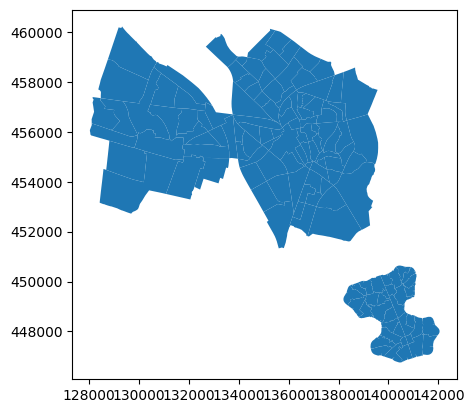

In [3]:
##### CREATE MAP #####
file_path = '../data/buurt_2020_v3.shp'
buurten_map = gpd.read_file(file_path)

gem_map = buurten_map.loc[buurten_map['GM_NAAM'].isin(gemeente_selectie)]

drop_buurten_houten = ['Buitengebied Houten West',
       'Buitengebied Houten Oost', "Dorp 't Goy", "'t Goyse Dorp",
       "Buitengebied 't Goy", "'t Waal", 'Tull',
       "Buitengebied Tull en 't Waal", 'Dorp Schalkwijk West',
       'Dorp Schalkwijk Oost', 'Buitengebied Schalkwijk West',
       'Buitengebied Schalkwijk Oost','Bruggen', 'Bogen', 'De Poel',
       'Schepen', 'Boten', 'Honen', 'Kaden', 'Vesten', 'De Staart',
       'Hof van Wulven', 'Rondweg Noord-Oost', 'Rondweg Noord-West',
       'Rondweg Zuid-Oost', 'Rondweg Zuid-West'] 

drop_buurten_utrecht = [
       'Bedrijventerrein Lageweide',
       'Haarzuilens en omgeving',
       'Bedrijventerrein en omgeving',
       'Utrecht Science Park',
              'Bedrijvengebied Strijkviertel', 
              'Bedrijvengebied Papendorp',
              'Rijnenburg',
              'Poldergebied Overvecht' ,
              ]

gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_houten)]
gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_utrecht)]

gem_map.plot()

# plt.savefig('plots/gem_map.png')

In [4]:
##### CREATE DATASET #####
totale_dataset = pd.read_excel('../data/kwb-2022.xlsx')
gemeente = totale_dataset.loc[totale_dataset['gm_naam'].isin(gemeente_selectie)]
buurten = gemeente.loc[gemeente['recs'] == 'Buurt']

nabijheid = pd.read_csv('../data/Nabijheid_voorzieningen__buurt_2019_02012023_192042.csv' , delimiter=';')
nabijheid = nabijheid.loc[nabijheid['Regioaanduiding/Soort regio (omschrijving)'] == 'Buurt     ']

buurten = buurten.merge(nabijheid, left_on='gwb_code_10', right_on='Regioaanduiding/Codering (code)')

In [5]:
### CREATE INPUT DATASET
gebruikte_variabelen = {
    'buurt_code': 'gwb_code_10',
    'regio':'regio',
    'aantal inwoners': 'a_inw',
    'inwoners tussen 25 en 44':'a_25_44',
    'westerse inwoners': 'a_w_all',
    'huishoudens met kinderen': 'a_hh_m_k',
    'gemiddele huishoudgrootte': 'g_hhgro', 
    'woningvoorraad': 'a_woning',
    'gemiddelde woz waarde':'g_woz',
    'percentage eengezinswoning': 'p_1gezw',
    'percentage meergezinswoning': 'p_mgezw',
    'percentage koopwoningen': 'p_koopw', 
    'bouwjaar na 2000': 'p_bjo2k',
    'Personen autos per huishouden': 'g_pau_hh',
    'Omgevingsadressendichtheid ':'ste_oad',
    'afstand tot huisarts': 'Gezondheid en welzijn/Huisartsenpraktijk/Afstand tot huisartsenpost (km)',
    'afstand tot apotheek': 'Gezondheid en welzijn/Afstand tot apotheek (km)', 
    'afstand tot supermarkt':  'Detailhandel/Winkels dagelijkse boodschappen/Afstand tot grote supermarkt (km)',
    'afstand tot warenhuis':  'Detailhandel/Warenhuis/Afstand tot warenhuis (km)',
    'afstand tot cafe':  'Horeca/Cafés en dergelijke/Afstand tot café e.d. (km)',
    'afstand tot oprit hoofdverkeersweg' : 'Verkeer en vervoer/Afstand tot oprit hoofdverkeersweg (km)',
    'afstand tot trein':  'Verkeer en vervoer/Treinstations/Afstand tot treinstations totaal (km)',
    }    

lijst_gebruik = []
[lijst_gebruik.append(values) for key, values in gebruikte_variabelen.items()]
analyse_dataset = buurten[lijst_gebruik]

y_columns = ['gwb_code_10', 'regio']
Y = analyse_dataset[['gwb_code_10', 'regio']]
X = analyse_dataset[analyse_dataset.columns[~analyse_dataset.columns.isin(y_columns)]]

In [6]:
##### FEATURE PREP ######
clean_up_columns = ['g_hhgro', 'g_woz', 'p_1gezw', 'p_mgezw',
'p_koopw', 'p_bjo2k', 'g_pau_hh','ste_oad',
'Gezondheid en welzijn/Huisartsenpraktijk/Afstand tot huisartsenpost (km)',
'Gezondheid en welzijn/Afstand tot apotheek (km)',
'Detailhandel/Winkels dagelijkse boodschappen/Afstand tot grote supermarkt (km)',
'Detailhandel/Warenhuis/Afstand tot warenhuis (km)',
'Horeca/Cafés en dergelijke/Afstand tot café e.d. (km)',
'Verkeer en vervoer/Afstand tot oprit hoofdverkeersweg (km)',
'Verkeer en vervoer/Treinstations/Afstand tot treinstations totaal (km)'
]

for column in clean_up_columns:
    X[column] = X[column].replace(",", ".", regex=True)  
    X[column] = X[column].replace('       .', '.', regex=True)    
    X.loc[X[column] == '.', column] = 0
    X[column] = X[column].astype(float).astype(int)


/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_61212/2014059138.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].replace(",", ".", regex=True)
/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_61212/2014059138.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].replace('       .', '.', regex=True)
/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_61212/2014059138.py:17: SettingWithCopyWarning: 
A value is trying to be set on a co

In [7]:
##### SIMILARITY ######

cosine_sim_matrix = cosine_similarity(X, X)

# Function that gets movie recommendations based on the cosine similarity score of movie genres
def buurten_recommendations(regio, map_df, n_predictions, analyse_dataset, cosine_sim_matrix, hernoemen_features):
    buurten = analyse_dataset['regio']
    indices = pd.Series(analyse_dataset.index, index=analyse_dataset['regio']) 

    # create dataframe with predictions
    idx = indices[regio]
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n_predictions+1]
    scores = [i[1] for i in sim_scores]
    scores = [round(score,4) for score in scores]
    buurten_indices = [i[0] for i in sim_scores]
    recommendations = buurten.iloc[buurten_indices]
    recommendations_df = pd.DataFrame(list(zip(recommendations, scores)))
    recommender_lijst = np.append(recommendations_df[0].unique(), regio)
    
    # create plot with predictions
    merged_df = map_df.merge(recommendations_df, left_on='BU_NAAM', right_on=0, how='left')
    merged_df.loc[~merged_df[1].isnull(),'dummy'] = 1
    merged_df.loc[merged_df[1].isnull(),'dummy'] = 0.5
    merged_df.loc[merged_df['BU_NAAM'] == regio, 'dummy'] = 0

    # Maak een thematische kaart
    p = merged_df.plot(column="dummy",
                        figsize = (6,4),
                        cmap='RdYlGn')
    p.axis('off')
    p.set_title(f'Voor jouw buurt "{regio}", woorden de volgende buurten geadvisereed:')

    # explore datsets
    geometry = map_df[['geometry', 'BU_NAAM']]
    explore = geometry.merge(analyse_dataset, left_on='BU_NAAM', right_on='regio', how='left')
    explore = explore.loc[explore['BU_NAAM'].isin(recommender_lijst)]
    explore = explore.loc[explore['BU_NAAM'].isin(recommender_lijst)]

    
    print(type(explore))
    # visualisatie van welke kolommen
    features_visualisatie = ['BU_NAAM', 'a_inw', 'a_25_44','a_woning', 'p_koopw', 'g_woz','p_bjo2k','geometry']
    explore = explore[explore.columns[explore.columns.isin(features_visualisatie)]]
    explore.rename(columns=hernoemen_features, inplace=True)
    return recommender_lijst, explore

In [8]:
jasmee_buurt = 'Oud Hoograven-Zuid'
haja_buurt = 'Slagen'
nelize_buurt = 'Voordorp en Voorveldsepolder'

<class 'geopandas.geodataframe.GeoDataFrame'>
We raden de volgende buurten aan: 
Campen
Muren
Parkwijk-Noord
Waters
Velden
Slagen


[None, None, None, None, None, None]

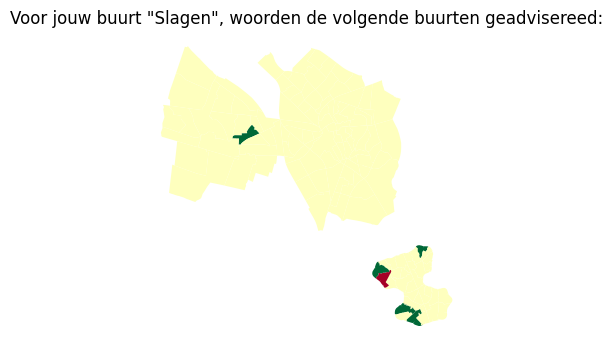

In [21]:
hernoemen_features = {
        'BU_NAAM': 'naam van de buurt',
        'a_inw': 'aantal inwoners',
        'a_25_44': 'inwoners tussen 25 en 44',
        'a_woning': 'woningvoorraad (per 1 jan)',
        'p_koopw': 'percentage koopwoningen',
        'g_woz' : 'gemiddelde woz waarde',
        'p_bjo2k': 'bouwjaar na 2000',
        'geometry': 'geometry'}

lijst, explore = buurten_recommendations('Slagen', gem_map, 5, analyse_dataset, cosine_sim_matrix, hernoemen_features)
print('We raden de volgende buurten aan: ')
[print(i) for i in lijst]

In [22]:
explore_interaction = explore.explore(popup=True)

# and then we write the map to disk
explore_interaction.save('recommendations_map.html')

# then open it
webbrowser.open('file://' + os.path.realpath('recommendations_map.html'))

True